# Lab 4: Classification (Part 2) and Model Selection

## Name: Matthew Wei (mswei2)

### Due Sept 29th, 2023 11:59 PM

**Logistics and Lab Submission**

Upload the pdf and code to Gradescope.

**What You Will Need To Know For This Lab**

This lab covers a few more basic classifiers which can be used for M-ary classification:
- Naive Bayes

as well as cross-validation, a tool for model selection and assessment.
 

Remember in many applications, the end goal is not always "run a classifier", like in a homework problem, but is to use the output of the classifier in the context of the problem at hand (e.g. detecting spam, identifying cancer, etc.). Because of this, some of our Engineering Design-type questions are designed to get you to think about the entire design problem at a high level.


**Warning: Do not train on your test sets. You will automatically get zero points**

**Preamble (don't change this)**

In [14]:
from __future__ import division
%pylab inline
import numpy as np
from sklearn import neighbors
from sklearn import svm
#from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from numpy import genfromtxt
from sklearn.preprocessing import MinMaxScaler
import glob

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Problem 1: Spam Detection (70 points)

In this problem, you will be constructing a crude spam detector. As you all know, when you receive an e-mail, it can be divided into one of two types: ham (useful mail, label $-1$) and spam (junk mail, label $+1$). In the [olden days](http://www.paulgraham.com/spam.html), people tried writing a bunch of rules to detect spam. However, it was quickly seen that machine learning approaches work fairly well for a little bit of work. 

You will be designing a spam detector by applying some of the classification techniques you learned in class to a batch of emails used to train and test [SpamAssassin](http://spamassassin.apache.org/), a leading anti-spam software package. 

Let the *vocabulary* of a dataset be a list of all terms occuring in a data set. So, for example, a vocabulary could be ["cat","dog","chupacabra", "aerospace", ...]. 

Our features will be based only the frequencies of terms in our vocabulary occuring in the e-mails (such an approach is called a *bag of words* approach, since we ignore the positions of the terms in the emails). The $j$-th feature is the number of times term $j$ in the vocabulary occurs in the email. If you are interested in further details on this model, you can see Chapters 6 and 13 in [Manning's Book](http://nlp.stanford.edu/IR-book/).

You will use the following classifiers in this problem:
- sklearn.naive_bayes.BernoulliNB (Naive Bayes Classifier with Bernoulli Model)
- sklearn.naive_bayes.MultinomialNB (Naive Bayes Classifier with Multinomial Model)
- sklearn.svm.LinearSVC (Linear Support Vector Machine)
- sklearn.neighbors.KNeighborsClassifier (1-Nearest Neighbor Classifier)

In the context of the Bernoulli Model for Naive Bayes, scikit-learn will binarize the features by interpretting the $j$-th feature to be $1$ if the $j$-th term in the vocabulary occurs in the email and $0$ otherwise. This is a categorical Naive Bayes model, with binary features. While we did not discuss the multinomial model in class, it operates directly on the frequencies of terms in the vocabulary, and is discussed in Section 13.2 in [Manning's Book](http://nlp.stanford.edu/IR-book/) (though you do not need to read this reference). Both the Bernoulli and Multinomial models are commonly used for Naive Bayes in text classification. 

A sample Ham email is:

    From nic@starflung.com  Mon Jun 24 17:06:54 2002
    Return-Path: 7910726.0.27May2002215326@mp.opensrs.net
    Delivery-Date: Tue May 28 02:53:28 2002
    Received: from mp.opensrs.net (mp.opensrs.net [216.40.33.45]) by
        dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g4S1rSe14718 for
        <zzz@spamassassin.taint.org>; Tue, 28 May 2002 02:53:28 +0100
    Received: (from popensrs@localhost) by mp.opensrs.net (8.9.3/8.9.3) id
        VAA04361; Mon, 27 May 2002 21:53:26 -0400
    Message-Id: <7910726.0.27May2002215326@mp.opensrs.net>
    Date: Mon, 27 May 2002 21:53:26 -0500 (EST)
    From: "Starflung NIC" <nic@starflung.com>
    To: <zzz@spamassassin.taint.org>
    Subject: Automated 30 day renewal reminder 2002-05-27
    X-Keywords: 

    The following domains that are registered as belonging
    to you are due to expire within the next 60 days. If
    you would like to renew them, please contact
    nic@starflung.com; otherwise they will be deactivated
    and may be registered by another.


    Domain Name, Expiry Date
    nutmegclothing.com, 2002-06-26
    
    
A sample Spam email is: 

    From jjj@mymail.dk  Fri Aug 23 11:03:31 2002
    Return-Path: <jjj@mymail.dk>
    Delivered-To: zzzz@localhost.example.com
    Received: from localhost (localhost [127.0.0.1])
        by phobos.labs.example.com (Postfix) with ESMTP id 478B54415C
        for <zzzz@localhost>; Fri, 23 Aug 2002 06:02:57 -0400 (EDT)
    Received: from mail.webnote.net [193.120.211.219]
        by localhost with POP3 (fetchmail-5.9.0)
        for zzzz@localhost (single-drop); Fri, 23 Aug 2002 11:02:57 +0100 (IST)
    Received: from smtp.easydns.com (smtp.easydns.com [205.210.42.30])
        by webnote.net (8.9.3/8.9.3) with ESMTP id IAA08912;
        Fri, 23 Aug 2002 08:13:36 +0100
    From: jjj@mymail.dk
    Received: from mymail.dk (unknown [61.97.34.233])
        by smtp.easydns.com (Postfix) with SMTP
        id 7484A2F85C; Fri, 23 Aug 2002 03:13:31 -0400 (EDT)
    Reply-To: <jjj@mymail.dk>
    Message-ID: <008c61d64eed$6184e5d5$4bc22de3@udnugg>
    To: bbr_hooten@yahoo.com
    Subject: HELP WANTED.  WORK FROM HOME REPS.
    MiME-Version: 1.0
    Content-Type: text/plain;
        charset="iso-8859-1"
    X-Priority: 3 (Normal)
    X-MSMail-Priority: Normal
    X-Mailer: Microsoft Outlook, Build 10.0.2616
    Importance: Normal
    Date: Fri, 23 Aug 2002 03:13:31 -0400 (EDT)
    Content-Transfer-Encoding: 8bit

    Help wanted.  We are a 14 year old fortune 500 company, that is
    growing at a tremendous rate.  We are looking for individuals who
    want to work from home.

    This is an opportunity to make an excellent income.  No experience
    is required.  We will train you.

    So if you are looking to be employed from home with a career that has
    vast opportunities, then go:

    http://www.basetel.com/wealthnow

    We are looking for energetic and self motivated people.  If that is you
    than click on the link and fill out the form, and one of our
    employement specialist will contact you.

    To be removed from our link simple go to:

    http://www.basetel.com/remove.html


    1349lmrd5-948HyhJ3622xXiM0-290VZdq6044fFvN0-799hUsU07l50



First, we will load the data. Our dataset has a bit over 9000 emails, with about 25% of them being spam. We will use 50% of them as a training set, 25% of them as a validation set and 25% of them as a test set. 

In [17]:
# Get list of emails
spamfiles=glob.glob('./Spam/*')
hamfiles=glob.glob('./Ham/*')

In [18]:
# First, we will split the files into the training, validation and test sets.

np.random.seed(seed=222017) # seed the RNG for repeatability

fnames=np.asarray(spamfiles+hamfiles)
nfiles=fnames.size
labels=np.ones(nfiles)
labels[len(spamfiles):]=-1

# Randomly permute the files we have
idx=np.random.permutation(nfiles)
fnames=fnames[idx]
labels=labels[idx]

#Split the file names into which set they belong to
tname=fnames[:int(nfiles/2)]
trainlabels=labels[:int(nfiles/2)]
vname=fnames[int(nfiles/2):int(nfiles*3/4)]
vallabels=labels[int(nfiles/2):int(nfiles*3/4)]
tename=fnames[int(3/4*nfiles):]
testlabels=labels[int(3/4*nfiles):]

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

# Get our Bag of Words Features from the data
bow = CountVectorizer(input='filename',encoding='iso-8859-1',binary=False)
traindata=bow.fit_transform(tname)
valdata=bow.transform(vname)
testdata=bow.transform(tename)
print ("done")

done


The $100$ most and least common terms in the vocabulary are:

In [21]:
counts=np.reshape(np.asarray(np.argsort(traindata.sum(axis=0))),-1)
vocab=np.reshape(np.asarray(bow.get_feature_names_out()),-1)
print ("100 most common terms: " , ','.join(str(s) for s in vocab[counts[-100:]]), "\n")
print ("100 least common terms: " , ','.join(str(s) for s in vocab[counts[:100]]))

100 most common terms:  slashnull,dogma,ist,thu,not,lists,cnet,mail,wed,as,html,have,click,jmason,exmh,00,are,align,freshrpms,or,mailman,date,text,mon,message,12,postfix,type,arial,users,bgcolor,ie,rpm,linux,version,22,be,taint,your,mailto,sourceforge,admin,content,20,color,table,jm,on,aug,border,127,example,face,href,this,nbsp,gif,09,subject,10,img,src,sep,it,that,0100,spamassassin,height,esmtp,is,size,xent,fork,you,tr,www,in,list,11,br,width,received,localhost,id,of,and,org,by,with,net,for,td,http,2002,font,from,3d,to,the,com 

100 least common terms:  g6mn17405760,e17titx,e17tvdy,e17ueb2,e17vjs8,e17vjsf,e17w5r4,e17wchv,e17wcmr,s4tkh2qxhrdntbervcuydvpgt4frugzlf3xwvohcrdtxohcfpaziiaed0ne9lw5,e17wosd,e17wosk,e17wssb,e17titf,e17wsyl,e17xbmd,e17xd4y,e17xlhj,e17yawz,s4lyze220qd,e17yozl,e17ysm1,e17ysna,e17ysox,e17ywux,e17z5re,e17z65d,e17wved,e17tfo0,e17texc,e17stjj,e17kazn,e17kb3f,e17kb3l,e17kba2,e17kcfg,e17kkxb,e17kxx7,e17kxxd,e17lk0h,e17lzkx,e17m2xi,e17mbzo,e17mpr7,e17n4br,e17n8od,e17nmu

We will have our training data in `traindata` (with labels in `trainlabels`), validation data in `valdata` (with labels in `vallabels`) and test data in `testdata` (with labels in `testlabels`).

For each of the following classifiers **(10 points each)**:
- sklearn.naive_bayes.BernoulliNB (Naive Bayes Classifier with Bernoulli Model)
- sklearn.naive_bayes.MultinomialNB (Naive Bayes Classifier with Multinomial Model)
- sklearn.svm.LinearSVC (Linear Support Vector Machine)
- sklearn.neighbors.KNeighborsClassifier (as a 1-Nearest Neighbor Classifier)

In this question, you are required to finish the followings:
1. Train on the training data in `traindata` with corresponding labels `trainlabels`. Use the default parameters, unless otherwise noted.
2. Report Training Error.
3. Report Validation Error.
4. Report the time it takes to fit the classifier (i.e. time to perform xxx.fit(X,y)).
5. Report the time it takes to run the classifier on the validation data (i.e. time to perform xxx.predict(X,y)).



In [31]:
# Put your code here

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

#q1 = Question1()
classifier_list = ["BernoulliNB", "MultinomialNB", "LinearSVC", "NN"]

classifier = BernoulliNB()
start = time.time()
classifier.fit(traindata,trainlabels)
end = time.time()
fittingTime = end - start
predictLabels = classifier.predict(traindata)
trainingError = np.mean(trainlabels!=predictLabels)
start = time.time()
predictLabels = classifier.predict(valdata)
end = time.time()
predictingTime = end_point - start_point
validationError = np.mean(vallabels!=predictLabels)

print("BernoulliNB Cassifier:")
print("Training Error: %.3f" % trainingError)
print("Validation Error: %.3f" % validationError)
print("Fitting Time: %.5f sec" % fittingTime)
print("Predicting Time: %.5f sec" % valPredictingTime)
print("")

classifier = MultinomialNB()
start = time.time()
classifier.fit(traindata,trainlabels)
end = time.time()
fittingTime = end - start
predictLabels = classifier.predict(traindata)
trainingError = np.mean(trainlabels!=predictLabels)
start = time.time()
predictLabels = classifier.predict(valdata)
end = time.time()
predictingTime = end_point - start_point
validationError = np.mean(vallabels!=predictLabels)

print("MultinomialNB Classifier:")
print("Training Error: %.3f" % trainingError)
print("Validation Error: %.3f" % validationError)
print("Fitting Time: %.5f sec" % fittingTime)
print("Predicting Time: %.5f sec" % valPredictingTime)
print("")

classifier = LinearSVC()
start = time.time()
classifier.fit(traindata,trainlabels)
end = time.time()
fittingTime = end - start
predictLabels = classifier.predict(traindata)
trainingError = np.mean(trainlabels!=predictLabels)
start = time.time()
predictLabels = classifier.predict(valdata)
end = time.time()
predictingTime = end_point - start_point
validationError = np.mean(vallabels!=predictLabels)

print("LinearSVC Classifier:")
print("Training Error: %.3f" % trainingError)
print("Validation Error: %.3f" % validationError)
print("Fitting Time: %.5f sec" % fittingTime)
print("Predicting Time: %.5f sec" % valPredictingTime)
print("")

classifier = KNeighborsClassifier(n_neighbors=1)
start = time.time()
classifier.fit(traindata,trainlabels)
end = time.time()
fittingTime = end - start
predictLabels = classifier.predict(traindata)
trainingError = np.mean(trainlabels!=predictLabels)
start = time.time()
predictLabels = classifier.predict(valdata)
end = time.time()
predictingTime = end_point - start_point
validationError = np.mean(vallabels!=predictLabels)

print("NN Classifier:")
print("Training Error: %.3f" % trainingError)
print("Validation Error: %.3f" % validationError)
print("Fitting Time: %.5f sec" % fittingTime)
print("Predicting Time: %.5f sec" % valPredictingTime)

BernoulliNB Cassifier:
Training Error: 0.034
Validation Error: 0.055
Fitting Time: 0.05107 sec
Predicting Time: 4.61699 sec

MultinomialNB Classifier:
Training Error: 0.019
Validation Error: 0.027
Fitting Time: 0.02905 sec
Predicting Time: 4.61699 sec



C:\Users\matt3\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC Classifier:
Training Error: 0.000
Validation Error: 0.011
Fitting Time: 1.39243 sec
Predicting Time: 4.61699 sec

NN Classifier:
Training Error: 0.000
Validation Error: 0.016
Fitting Time: 0.02122 sec
Predicting Time: 4.61699 sec


**Extra (not evaluated):** Based on the results of this problem and knowledge of the application at hand (spam filtering), pick one of the classifiers in this problem and describe how you would use it as part of a spam filter for the University of Illinois email system. Sketch out a system design at a very high level -- how you would train the spam filter to deal with new threats, would you filter everyone's email jointly, etc. You may get some inspiration from the [girls and boys](https://gmail.googleblog.com/2007/10/how-our-spam-filter-works.html) at [Gmail](https://gmail.googleblog.com/2015/07/the-mail-you-want-not-spam-you-dont.html), the [chimps at MailChimp](http://kb.mailchimp.com/delivery/spam-filters/about-spam-filters) or other places.

Write a function that calculates the confusion matrix. . **(10 points)**

Run the classifier you selected in the previous part of the problem on the test data. The following code displays the test error and the output of the function. **(10 points)**

In [35]:
# Put your code here
classifier = LinearSVC()
classifier.fit(traindata,trainlabels)
estimatedlabels = classifier.predict(testdata)
testError = np.mean(testlabels!=estimatedlabels)
confusionmatrix = np.zeros((2,2))
confusionmatrix[0,0]=np.sum(np.logical_and(testlabels==1, estimatedlabels==1))
confusionmatrix[0,1]=np.sum(np.logical_and(testlabels==-1, estimatedlabels==1))
confusionmatrix[1,0]=np.sum(np.logical_and(testlabels==1, estimatedlabels==-1))
confusionmatrix[1,1]=np.sum(np.logical_and(testlabels==-1, estimatedlabels==-1))
print("Test Error: %3f" % testError)
print ("True Positives:", confusionmatrix[0,0], "False Positive:", confusionmatrix[0,1])
print ("False Negative:", confusionmatrix[1,0], "True Negatives:", confusionmatrix[1,1])
print ("True Positive Rate : ", confusionmatrix[0,0]/(confusionmatrix[0,0] + confusionmatrix[1,0]))
print ("False Positive Rate: ", confusionmatrix[0,1]/(confusionmatrix[0,1] + confusionmatrix[1,1]))

Test Error: 0.010693
True Positives: 615.0 False Positive: 20.0
False Negative: 5.0 True Negatives: 1698.0
True Positive Rate :  0.9919354838709677
False Positive Rate:  0.011641443538998836


C:\Users\matt3\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


As a sanity check, you should observe that your true positive rate is above 0.95 (i.e. highly sensitive).

### Problem 2: Cross-Validation (50 Points)

Now, we will load some data (acquired from <a href="http://www.cs.ubc.ca/~murphyk/">K.P. Murphy</a>'s <a href="https://github.com/probml/pmtk3"> PMTK tookit</a>).

In [36]:
problem2_tmp= genfromtxt('p2.csv', delimiter=',')

# Randomly reorder the data
np.random.seed(seed=2217) # seed the RNG for repeatability
idx=np.random.permutation(problem2_tmp.shape[0])
problem2_tmp=problem2_tmp[idx]

#The training data which you will use is called "traindata"
traindata=problem2_tmp[:200,:2]
#The training labels are in "labels"
trainlabels=problem2_tmp[:200,2]

#The test data which you will use is called "testdata" with labels "testlabels"
testdata=problem2_tmp[200:,:2]
testlabels=problem2_tmp[200:,2]

# You should not re-shuffle your data in your functions!

Write a function which implements $5$-fold cross-validation to estimate the error of a classifier with cross-validation with the 0,1-loss for k-Nearest Neighbors (kNN). 

You will be given as input:
* A (N,d) numpy.ndarray of training data, *trainData* (with N divisible by 5)
* A length $N$ numpy.ndarray of training labels, *trainLabels*
* A number $k$, for which cross-validated error estimates will be outputted for $1,\ldots,k$

Your output will be a vector (represented as a numpy.ndarray) *err*, such that *err[i]* is the cross-validated estimate of using i neighbors (*err* will be of length $k+1$; the zero-th component of the vector will be meaningless). 

**For this problem, take your folds to be 0:N/5, N/5:2N/5, ..., 4N/5:N for cross-validation (In general, however, the folds should be randomly divided).**

Use scikit-learn's sklearn.neighbors.KNeighborsClassifier to perform the training and classification for the kNN models involved.  <b>(25 points)</b>

Write a function that *calls the above function* and returns 1) the output from the previous function, 2) the number of neighbors within $1,\ldots,30$ that minimizes the cross-validation error, and 3) the correponding minimum error. <b>(15 points)</b>

The following code helps you to visualize your result. It plots the cross-validation error with respect to the number of neighbors. Your best number of neighbors should be roughly at the middle of your err array.

The best number of neighbors is: 14
The corresponding error is: 0.175


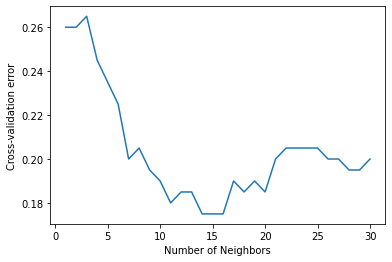

In [44]:
#q2 = Question2()
#err, k_min, err_min = q2.minimizer_K(traindata,trainlabels,30)
N = traindata.shape[0]
d = traindata.shape[1]
traindatacross = []
trainlabelcross = []
for i in range(5):
    traindatacross.append(np.delete(traindata, np.s_[int(i*N/5):int((i+1)*N/5)], 0))
    trainlabelcross.append(np.delete(trainlabels, np.s_[int(i*N/5):int((i+1)*N/5)], 0))

err = np.zeros(31)
for i in range(1, 31):
    model = KNeighborsClassifier(n_neighbors = i,weights='distance')
    for j in range(5):
        model.fit(traindatacross[j],trainlabelcross[j])
        err[i]+=(1 - model.score(traindata[int(j*N/5):int((j+1)*N/5)], trainlabels[int(j*N/5):int((j+1)*N/5)]))/5

def minimizer_K(kNN_errors):
    k_min = np.argmin(kNN_errors[1: kNN_errors.shape[0]]) + 1
    err_min = kNN_errors[k_min]
    return (k_min, err_min)

k_min, err_min = minimizer_K(err)
    
plot(np.arange(1,31),err[1:])
xlabel('Number of Neighbors')
ylabel('Cross-validation error')
axis('tight')
print("The best number of neighbors is:", k_min)
print("The corresponding error is:", err_min)

Train a kNN model on the whole training data using the number of neighbors you found in the previous part of the question, and apply it to the test data. **(10 points)**

In [45]:
#_, testError = q2.classify(traindata, trainlabels, testdata, testlabels)
classifier = KNeighborsClassifier(n_neighbors=k_min)
classifier.fit(traindata, trainlabels)
predtestlabels = classifier.predict(testdata)
testError = np.mean(testlabels!=predtestlabels)

print("The test error is:", testError)

The test error is: 0.214


As a sanity check, the test error should be around 0.2.

## And this concludes Lab 4! Congratulations!